# **Driver Behavior Detection using CNN and Pre-trained Models**

# Importing Libraries

In this section, we import the essential libraries and tools for data analysis, image processing, and building CNN models:

- `numpy` → for numerical operations and arrays.  
- `pandas` → for managing data in DataFrames.  
- `os` → for handling files and directories.  
- `PIL.Image` → for opening and processing images.  
- `matplotlib.pyplot` → for plotting images and graphs.  
- `skimage.io.imread` → for reading images in different formats.  
- `sklearn.model_selection.train_test_split` → for splitting data into Train/Validation/Test sets.  
- `tensorflow.keras` → for building and training CNN models:  
  - Layers: `Conv2D`, `MaxPooling2D`, `Flatten`, `Dense`, `Dropout`, `BatchNormalization`  
  - Models: `Sequential`  
  - Preprocessing: `ImageDataGenerator`  
  - Optimizers: `Adamax`

In [3]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
from skimage.io import imread
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Loading Image Paths

In this section, we list all the available classes (labels) and define a function to load image file paths from each folder.

- `base_path` → the main directory containing all class folders.  
- `labels` → list of all class names (folder names) inside `base_path`.  
- `load_images(folder)` → a function that:
  1. Receives a folder name.
  2. Joins it with the `base_path`.
  3. Returns a list of all image file paths in that folder with `.png` or `.jpg` extensions.

> This function will help us easily gather all image paths for each class for further processing.

In [4]:
base_path = "/kaggle/input/revitsone-5class/Revitsone-5classes"
labels = os.listdir(base_path)
print(labels)

# Function to load images from a folder
def load_images(folder):
    folder_path = os.path.join(base_path, folder)
    return [
        os.path.join(folder_path, img)
        for img in os.listdir(folder_path)
        if img.endswith(".png") or img.endswith(".jpg")
    ]

['other_activities', 'talking_phone', 'safe_driving', 'texting_phone', 'turning']


In [5]:
base_path = "/kaggle/input/revitsone-5class/Revitsone-5classes"
categories = ["other_activities", "safe_driving", "talking_phone", "texting_phone", "turning"]
images_dict = {}

for category in categories:
    category_path = os.path.join(base_path, category)
    images_list = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith(".png") or f.endswith(".jpg")]
    images_dict[category] = images_list

for category, imgs in images_dict.items():
    print(f"{category}: {len(imgs)} images")

other_activities: 2128 images
safe_driving: 2203 images
talking_phone: 2169 images
texting_phone: 2203 images
turning: 2063 images


# Loading All Categories

Here, we use the previously defined `load_images` function to load image paths for each class:

- `others_activities` → paths of images for miscellaneous activities.  
- `safe_driving` → paths of images where the driver is driving safely.  
- `talking_phone` → paths of images where the driver is talking on the phone.  
- `texting_phone` → paths of images where the driver is texting on the phone.  
- `turning` → paths of images showing the driver turning.

> This step organizes all image file paths by category, which will be useful for creating a labeled dataset.

In [6]:
# Load all categories
others_activities = load_images("other_activities")
safe_driving = load_images("safe_driving")
talking_phone = load_images("talking_phone")
texting_phone = load_images("texting_phone")
turning = load_images("turning")

In [7]:
print(texting_phone[0], turning[0], talking_phone[0], safe_driving[0], others_activities[0], sep="\n")

/kaggle/input/revitsone-5class/Revitsone-5classes/texting_phone/img_38942.jpg
/kaggle/input/revitsone-5class/Revitsone-5classes/turning/img_13562.jpg
/kaggle/input/revitsone-5class/Revitsone-5classes/talking_phone/img_4913.jpg
/kaggle/input/revitsone-5class/Revitsone-5classes/safe_driving/img_12470.jpg
/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_25688.jpg


# Removing Unwanted Images

Sometimes, some images are corrupted, mislabeled, or unsuitable for training.  
Here, we define lists of unwanted images for specific categories:

- `unwanted_others` → images in the `other_activities` class that should be excluded.  
- `unwanted_turning` → images in the `turning` class that should be excluded.

> These lists will be used later to remove these images from the dataset before creating the DataFrame.


In [8]:
unwanted_others = [
    "img_79.jpg", "img_4664.jpg", "img_7973.jpg", "img_13318.jpg",
    "img_13396.jpg", "img_13541.jpg", "img_13625.jpg",
    "img_20398.jpg", "img_22266.jpg"
]

unwanted_turning = [
    "img_8771.jpg", "img_62337.jpg", "img_67523.jpg",
    "img_70552.jpg", "img_84605.jpg", "img_101434.jpg"
]

## Removing Unwanted Images from Lists

We define a function to clean unwanted images from any list of image paths:

- `remove_unwanted(images_list, unwanted_names)`:
  1. Takes a list of image paths (`images_list`) and a list of unwanted file names (`unwanted_names`).  
  2. Returns a new list excluding any image whose filename matches one in `unwanted_names`.  

- Then, we apply this function to:
  - `others_activities` → remove `unwanted_others`
  - `turning` → remove `unwanted_turning`

> This ensures that our dataset is clean and ready for DataFrame creation and model training.

In [9]:
# Function to clean unwanted images from any list
def remove_unwanted(images_list, unwanted_names):
    return [img for img in images_list if os.path.basename(img) not in unwanted_names]

# Apply removal
others_activities = remove_unwanted(others_activities, unwanted_others)
turning = remove_unwanted(turning, unwanted_turning)


# Creating a Labeled DataFrame

In this section, we combine all the image paths and their corresponding labels into a single DataFrame for easier processing:

1. Create a dictionary `all_classes` where:
   - Key → class name (label)  
   - Value → list of image paths for that class  

2. Build a list of tuples `(image_path, label)` using list comprehension for all classes.  

3. Convert the list into a pandas DataFrame `df` with columns:
   - `image_path` → path to the image  
   - `label` → class label  

> This DataFrame will be used for train/test splitting and feeding images into the model.

In [10]:
import pandas as pd

# Dictionary of all lists
all_classes = {
    "others_activities": others_activities,
    "safe_driving": safe_driving,
    "talking_phone": talking_phone,
    "texting_phone": texting_phone,
    "turning": turning
}

# Build DataFrame
data = [(path, label) for label, paths in all_classes.items() for path in paths]

df = pd.DataFrame(data, columns=["image_path", "label"])
df.head(10)


,image_path,label
0,/kaggle/input/revitsone-5class/Revitsone-5clas...,others_activities
1,/kaggle/input/revitsone-5class/Revitsone-5clas...,others_activities
2,/kaggle/input/revitsone-5class/Revitsone-5clas...,others_activities
3,/kaggle/input/revitsone-5class/Revitsone-5clas...,others_activities
4,/kaggle/input/revitsone-5class/Revitsone-5clas...,others_activities
5,/kaggle/input/revitsone-5class/Revitsone-5clas...,others_activities
6,/kaggle/input/revitsone-5class/Revitsone-5clas...,others_activities
7,/kaggle/input/revitsone-5class/Revitsone-5clas...,others_activities
8,/kaggle/input/revitsone-5class/Revitsone-5clas...,others_activities
9,/kaggle/input/revitsone-5class/Revitsone-5clas...,others_activities


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10751 entries, 0 to 10750
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10751 non-null  object
 1   label       10751 non-null  object
dtypes: object(2)
memory usage: 168.1+ KB


# Splitting Data into Train, Validation, and Test Sets

In this step, we split the dataset into three parts to prepare for model training and evaluation:

1. **Train + Test split**:
   - `test_size=0.2` → 20% of the data will be used for testing.  
   - `stratify=df["label"]` → ensures that the class distribution is preserved in both sets.  
   - `random_state=42` → for reproducibility.  

2. **Train + Validation split**:
   - `test_size=0.2` → 20% of the training data will be used for validation.  
   - Stratified split ensures consistent class distribution.  

**Output**:
- `train_df` → used to train the model  
- `valid_df` → used to tune hyperparameters and monitor overfitting  
- `test_df` → used for final evaluation of model performance

In [13]:
# Train, Test split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Train + Validation split
train_df, valid_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df["label"],
    random_state=42
)

print("Number of rows in train dataframe is:", len(train_df))
print("Number of rows in validation dataframe is:", len(valid_df))
print("Number of rows in test dataframe is:", len(test_df))

Number of rows in train dataframe is: 6880
Number of rows in validation dataframe is: 1720
Number of rows in test dataframe is: 2151


# Visualizing Random Images from the 'Turning' Class

In this section, we display some sample images to understand the content and quality of our dataset:

1. Use `random.sample` to select 4 random images from the `turning` class.  
2. Plot the selected images in a 2x2 grid using `matplotlib.pyplot`.  
3. Remove axes for a cleaner visualization using `plt.axis('off')`.  
4. Add a title to the figure to indicate the class being visualized.

> This step helps in quickly inspecting the dataset and confirming that images are loaded correctly.

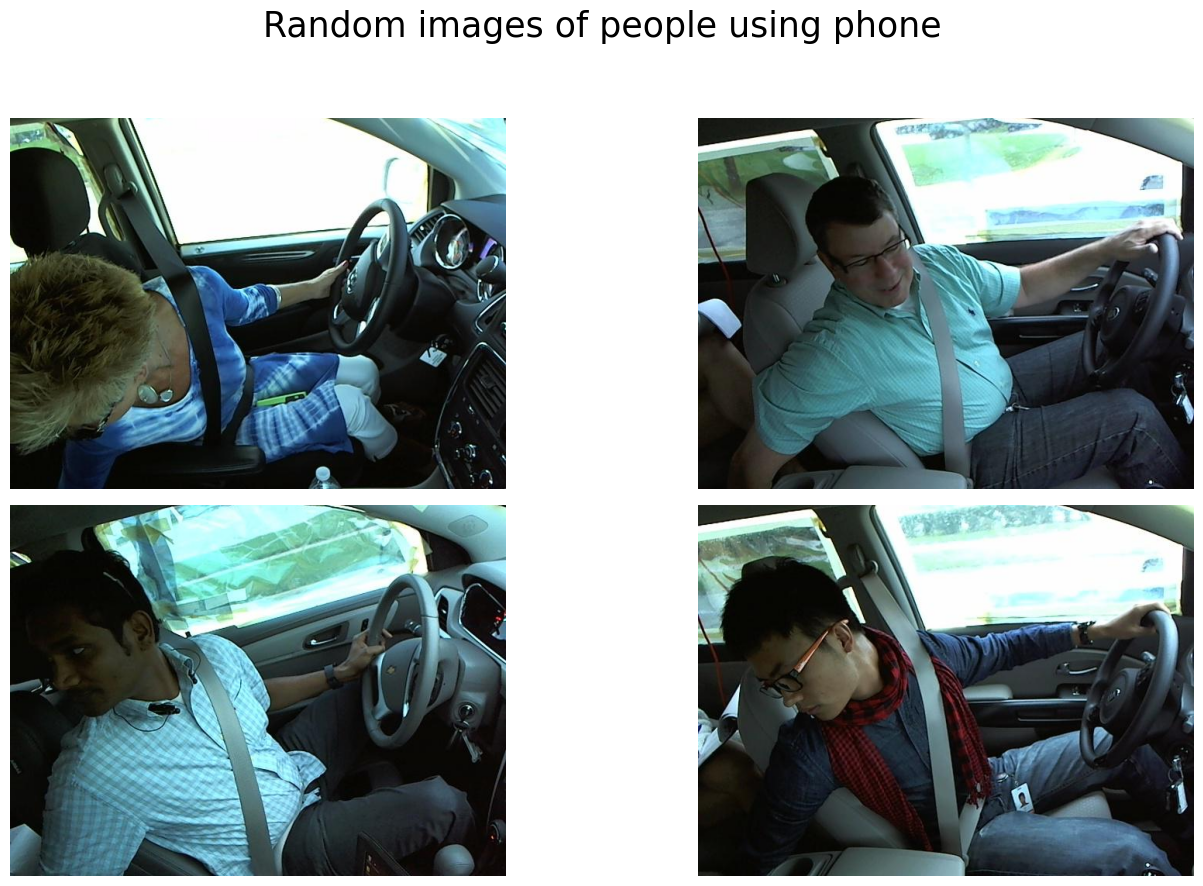

In [15]:
import random

plt.figure(figsize=(15, 9))
plt.suptitle(
    "Random images of people using phone",
    fontsize=25,
    backgroundcolor="white"
)

selected_images = random.sample(turning, 4)

for i, img_path in enumerate(selected_images, 1):
    img = imread(img_path)
    plt.subplot(2, 2, i)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.93]) 
plt.show()


# Image Augmentation and Preprocessing

In this section, we prepare the dataset for training the CNN by normalizing the images and creating data generators:

1. **Rescaling**:
   - Pixel values are scaled to the range [0, 1] using `rescale=1./255`.  
   - Helps the model converge faster during training.

2. **Data Generators**:
   - `train_aug` → generator for training images (can include augmentation later).  
   - `test_val_aug` → generator for validation and test images (only rescaling, no augmentation).

3. **Flow from DataFrame**:
   - `flow_from_dataframe` creates batches of images and labels directly from the DataFrame.  
   - Parameters:
     - `x_col="image_path"` → column with image paths  
     - `y_col="label"` → column with class labels  
     - `target_size=(240,240)` → resize images to 240x240  
     - `batch_size=32` → number of images per batch  
     - `class_mode="categorical"` → for multi-class classification

> These generators will feed images to the model during training, validation, and testing efficiently.

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rescale=1./255)

train_gen = gen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label",
    target_size=(240, 240),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=64,
    shuffle=True
)

valid_gen = gen.flow_from_dataframe(
    dataframe=valid_df,
    x_col="image_path",
    y_col="label",
    target_size=(240, 240),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

test_gen = gen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="label",
    target_size=(240, 240),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)


Found 6880 validated image filenames belonging to 5 classes.
Found 1720 validated image filenames belonging to 5 classes.
Found 2151 validated image filenames belonging to 5 classes.


# Modeling

## Building a Custom CNN Model

Here, we define a Convolutional Neural Network (CNN) for multi-class classification of driver behaviors:

**Architecture Overview**:

1. **Convolutional Blocks**:
   - Each block contains:
     - 2 Conv2D layers with `ReLU` activation and `BatchNormalization`
     - MaxPooling2D to reduce spatial dimensions
     - Dropout to prevent overfitting  
   - Number of filters increases in deeper blocks: 32 → 64 → 128 → 256

2. **Flattening**:
   - Converts 2D feature maps into 1D feature vector for Dense layers.

3. **Dense Layers**:
   - Fully connected layer with 512 neurons + BatchNormalization + Dropout
   - Output layer with 5 neurons (for 5 classes) and `softmax` activation for multi-class classification.

> This CNN is designed to extract hierarchical features from images while controlling overfitting with BatchNormalization and Dropout.

In [17]:
from tensorflow.keras import layers, models, Input
cnn_model = models.Sequential([
    
    # Block 1
    layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(240, 240, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.3),

    # Block 4
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.4),

    layers.Flatten(),

    # Dense Layers
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(5, activation='softmax')  # Change classes
])

cnn_model.summary()


I0000 00:00:1765568702.877594      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765568702.878196      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 240, 240, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 240, 240, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 240, 240, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 240, 240, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 120, 120, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 120, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 120, 120, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 120, 120, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 120, 120, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 120, 120, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 30, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 30, 30, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 30,672,421 (117.01 MB)

 Trainable params: 30,669,477 (116.99 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [18]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = cnn_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20


I0000 00:00:1765568762.764503     133 service.cc:148] XLA service 0x7a43b800ea40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765568762.765327     133 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765568762.765347     133 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765568763.743541     133 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-12-12 19:46:23.487333: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,240,240]{3,2,1,0}, f32[64,32,240,240]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_qu

 74/108 ━━━━━━━━━━━━━━━━━━━━ 15s 445ms/step - accuracy: 0.5094 - loss: 1.5935

2025-12-12 19:47:23.545275: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,240,240]{3,2,1,0}, f32[32,32,240,240]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-12-12 19:47:24.019511: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.474357773s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,240,240]{3,2,1,0}, f32[32,32,240,240]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"act

108/108 ━━━━━━━━━━━━━━━━━━━━ 135s 879ms/step - accuracy: 0.5628 - loss: 1.3984 - val_accuracy: 0.2012 - val_loss: 1.9030
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 471ms/step - accuracy: 0.8803 - loss: 0.3735 - val_accuracy: 0.2326 - val_loss: 4.0303
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 50s 462ms/step - accuracy: 0.9206 - loss: 0.2551 - val_accuracy: 0.3070 - val_loss: 2.1560
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 466ms/step - accuracy: 0.9541 - loss: 0.1389 - val_accuracy: 0.6564 - val_loss: 0.9320
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 469ms/step - accuracy: 0.9752 - loss: 0.0853 - val_accuracy: 0.8320 - val_loss: 0.4918
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 50s 463ms/step - accuracy: 0.9780 - loss: 0.0716 - val_accuracy: 0.9488 - val_loss: 0.1423
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 52s 479ms/step - accuracy: 0.9832 - loss: 0.0569 - val_accuracy: 0.9814 - val_loss: 0.0776
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 466ms/step - accuracy: 0.9903 - loss: 0.0416 - va

In [19]:
train_score = cnn_model.evaluate(train_gen, verbose= 1)
test_score = cnn_model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

108/108 ━━━━━━━━━━━━━━━━━━━━ 39s 256ms/step - accuracy: 0.9918 - loss: 0.0326
68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 240ms/step - accuracy: 0.9844 - loss: 0.0794
Train Loss:  0.03252854570746422
Train Accuracy:  0.992151141166687
--------------------
Test Loss:  0.08154569566249847
Test Accuracy:  0.98279869556427


## Building a VGG-like CNN Model

Here, we define a VGG-style Convolutional Neural Network for classifying driver behaviors:

**Architecture Overview**:

1. **Convolutional Blocks**:
   - **Block 1**: 2 Conv2D layers with 64 filters, ReLU activation → BatchNormalization → MaxPooling  
   - **Block 2**: 2 Conv2D layers with 128 filters → BatchNormalization → MaxPooling  
   - **Block 3**: 3 Conv2D layers with 256 filters → BatchNormalization → MaxPooling  
   - **Block 4**: 3 Conv2D layers with 512 filters → MaxPooling  

2. **Flattening**:
   - Convert feature maps into a 1D vector to feed fully connected layers.

3. **Fully Connected Layers**:
   - Dense layer with 4096 neurons + Dropout(0.5)  
   - Another Dense layer with 4096 neurons + Dropout(0.5)  
   - Output layer with 5 neurons (for 5 classes) + softmax activation

> This architecture follows the classic **VGG design**, capturing hierarchical features with deep convolutional layers and controlling overfitting with Dropout.


In [20]:
vgg_model=Sequential([
    Conv2D(64,(3,3),activation='relu',input_shape=(240,240,3)),
    Conv2D(64,(3,3),activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128,(3,3),activation='relu'),
    Conv2D(128,(3,3),activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(256,(3,3),activation='relu'),
    Conv2D(256,(3,3),activation='relu'),
    Conv2D(256,(3,3),activation='relu'),       
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(512,(3,3),activation='relu'),
    Conv2D(512,(3,3),activation='relu'),
    Conv2D(512,(3,3),activation='relu'),       
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax'),
                               
])
vgg_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 238, 238, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 236, 236, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 236, 236, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 118, 118, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 116, 116, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 114, 114, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 114, 114, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 57, 57, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 55, 55, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 53, 53, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 51, 51, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 51, 51, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 23, 23, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 21, 21, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 19, 19, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │   169,873,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 194,312,261 (741.24 MB)

 Trainable params: 194,311,365 (741.24 MB)

 Non-trainable params: 896 (3.50 KB)

In [21]:
vgg_model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss="categorical_crossentropy", 
    metrics=['accuracy']
)

In [22]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,          
    restore_best_weights=True 
)

In [23]:
VGG_model = vgg_model.fit(
    train_gen, epochs = 20,
    validation_data = valid_gen,
    callbacks = [early_stopping]
    
)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.3408 - loss: 15.7107 - val_accuracy: 0.2628 - val_loss: 2.5934
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.7381 - loss: 0.7125 - val_accuracy: 0.2192 - val_loss: 2.3822
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.8545 - loss: 0.4004 - val_accuracy: 0.2930 - val_loss: 1.6587
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9250 - loss: 0.2303 - val_accuracy: 0.3890 - val_loss: 1.8756
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9528 - loss: 0.1374 - val_accuracy: 0.6314 - val_loss: 1.0966
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9699 - loss: 0.0889 - val_accuracy: 0.9401 - val_loss: 0.1823
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9771 - loss: 0.0697 - val_accuracy: 0.9401 - val_loss: 0.1912
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9801 - loss: 0.0571 - val_acc

In [24]:
train_score = vgg_model.evaluate(train_gen, verbose= 1)
test_score = vgg_model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

108/108 ━━━━━━━━━━━━━━━━━━━━ 63s 344ms/step - accuracy: 0.9956 - loss: 0.0194
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 286ms/step - accuracy: 0.9701 - loss: 0.1314
Train Loss:  0.019400278106331825
Train Accuracy:  0.9954941868782043
--------------------
Test Loss:  0.1283743679523468
Test Accuracy:  0.9683867692947388


## Building a ResNet34-like CNN Model

Here, we define a **ResNet34-inspired architecture** using Keras Functional API for driver behavior classification:

**Architecture Overview**:

1. **Input**:
   - `Input((240, 240, 3))` for RGB images of size 240x240.

2. **Stem Layer**:
   - Initial Conv2D (64 filters, 7x7, stride 2) → BatchNormalization → ReLU → MaxPooling

3. **Residual Blocks**:
   - **Block 1**: 3 residual blocks with 64 filters  
   - **Block 2**: 4 residual blocks with 128 filters (first block downsamples)  
   - **Block 3**: 6 residual blocks with 256 filters (first block downsamples)  
   - **Block 4**: 3 residual blocks with 512 filters (first block downsamples)  
   - Each residual block:
     - Conv2D → BatchNormalization → ReLU → Conv2D → BatchNormalization → Add shortcut → ReLU

4. **Classifier**:
   - GlobalAveragePooling2D to reduce feature maps to vector  
   - Dense layer with 5 neurons + softmax for multi-class classification  

> This model uses **skip connections** to allow gradients to flow more easily during training, helping to train deeper networks effectively.

In [25]:
inp = Input((240, 240, 3))

# ---------- Stem ----------
x = layers.Conv2D(64, 7, strides=2, padding="same")(inp)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

# ---------- Block 1: 64 filters (3 residual blocks) ----------
# Block 1.1
shortcut = x
y = layers.Conv2D(64, 3, padding="same")(x)
y = layers.BatchNormalization()(y)
y = layers.ReLU()(y)
y = layers.Conv2D(64, 3, padding="same")(y)
y = layers.BatchNormalization()(y)
x = layers.add([shortcut, y])
x = layers.ReLU()(x)

# Block 1.2
shortcut = x
y = layers.Conv2D(64, 3, padding="same")(x)
y = layers.BatchNormalization()(y)
y = layers.ReLU()(y)
y = layers.Conv2D(64, 3, padding="same")(y)
y = layers.BatchNormalization()(y)
x = layers.add([shortcut, y])
x = layers.ReLU()(x)

# Block 1.3
shortcut = x
y = layers.Conv2D(64, 3, padding="same")(x)
y = layers.BatchNormalization()(y)
y = layers.ReLU()(y)
y = layers.Conv2D(64, 3, padding="same")(y)
y = layers.BatchNormalization()(y)
x = layers.add([shortcut, y])
x = layers.ReLU()(x)



# ---------- Block 2: 128 filters (4 residual blocks) ----------
# Block 2.1 (downsample)
shortcut = layers.Conv2D(128, 1, strides=2, padding="same")(x)
shortcut = layers.BatchNormalization()(shortcut)

y = layers.Conv2D(128, 3, strides=2, padding="same")(x)
y = layers.BatchNormalization()(y)
y = layers.ReLU()(y)
y = layers.Conv2D(128, 3, padding="same")(y)
y = layers.BatchNormalization()(y)

x = layers.add([shortcut, y])
x = layers.ReLU()(x)

# Blocks 2.2 – 2.4
for _ in range(3):
    shortcut = x
    y = layers.Conv2D(128, 3, padding="same")(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    y = layers.Conv2D(128, 3, padding="same")(y)
    y = layers.BatchNormalization()(y)
    x = layers.add([shortcut, y])
    x = layers.ReLU()(x)



# ---------- Block 3: 256 filters (6 residual blocks) ----------
# Block 3.1 (downsample)
shortcut = layers.Conv2D(256, 1, strides=2, padding="same")(x)
shortcut = layers.BatchNormalization()(shortcut)

y = layers.Conv2D(256, 3, strides=2, padding="same")(x)
y = layers.BatchNormalization()(y)
y = layers.ReLU()(y)
y = layers.Conv2D(256, 3, padding="same")(y)
y = layers.BatchNormalization()(y)

x = layers.add([shortcut, y])
x = layers.ReLU()(x)

# Blocks 3.2 – 3.6
for _ in range(5):
    shortcut = x
    y = layers.Conv2D(256, 3, padding="same")(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    y = layers.Conv2D(256, 3, padding="same")(y)
    y = layers.BatchNormalization()(y)
    x = layers.add([shortcut, y])
    x = layers.ReLU()(x)



# ---------- Block 4: 512 filters (3 residual blocks) ----------
# Block 4.1 (downsample)
shortcut = layers.Conv2D(512, 1, strides=2, padding="same")(x)
shortcut = layers.BatchNormalization()(shortcut)

y = layers.Conv2D(512, 3, strides=2, padding="same")(x)
y = layers.BatchNormalization()(y)
y = layers.ReLU()(y)
y = layers.Conv2D(512, 3, padding="same")(y)
y = layers.BatchNormalization()(y)

x = layers.add([shortcut, y])
x = layers.ReLU()(x)

# Blocks 4.2 – 4.3
for _ in range(2):
    shortcut = x
    y = layers.Conv2D(512, 3, padding="same")(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    y = layers.Conv2D(512, 3, padding="same")(y)
    y = layers.BatchNormalization()(y)
    x = layers.add([shortcut, y])
    x = layers.ReLU()(x)



# ---------- Classifier ----------
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(5, activation="softmax")(x)

model_ResNet34 = models.Model(inputs=inp, outputs=x)

In [26]:
model_ResNet34.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [27]:

callbacks = [
    EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True),
    ReduceLROnPlateau(monitor = "val_loss",factor = 0.3, patience=3),
    ModelCheckpoint("best_resnet34.h5", save_best_only=True, monitor="val_loss")
]


In [28]:
history = model_ResNet34.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=25,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.5276 - loss: 1.1871

108/108 ━━━━━━━━━━━━━━━━━━━━ 118s 715ms/step - accuracy: 0.5292 - loss: 1.1833 - val_accuracy: 0.2052 - val_loss: 8.2101 - learning_rate: 1.0000e-04
Epoch 2/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9347 - loss: 0.1996

108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 511ms/step - accuracy: 0.9348 - loss: 0.1993 - val_accuracy: 0.2349 - val_loss: 3.2362 - learning_rate: 1.0000e-04
Epoch 3/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 54s 501ms/step - accuracy: 0.9730 - loss: 0.0798 - val_accuracy: 0.2186 - val_loss: 9.0287 - learning_rate: 1.0000e-04
Epoch 4/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 504ms/step - accuracy: 0.9900 - loss: 0.0323 - val_accuracy: 0.2663 - val_loss: 5.5946 - learning_rate: 1.0000e-04
Epoch 5/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 504ms/step - accuracy: 0.9815 - loss: 0.0558 - val_accuracy: 0.3727 - val_loss: 4.7238 - learning_rate: 1.0000e-04
Epoch 6/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9935 - loss: 0.0234

108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 509ms/step - accuracy: 0.9935 - loss: 0.0233 - val_accuracy: 0.9209 - val_loss: 0.2326 - learning_rate: 3.0000e-05
Epoch 7/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 1.0000 - loss: 0.0012

108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 509ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9721 - val_loss: 0.0796 - learning_rate: 3.0000e-05
Epoch 8/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 1.0000 - loss: 6.6522e-04

108/108 ━━━━━━━━━━━━━━━━━━━━ 56s 515ms/step - accuracy: 1.0000 - loss: 6.6675e-04 - val_accuracy: 0.9820 - val_loss: 0.0610 - learning_rate: 3.0000e-05
Epoch 9/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 1.0000 - loss: 7.0229e-04

108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 512ms/step - accuracy: 1.0000 - loss: 7.0127e-04 - val_accuracy: 0.9849 - val_loss: 0.0541 - learning_rate: 3.0000e-05
Epoch 10/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 1.0000 - loss: 6.0421e-04

108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 507ms/step - accuracy: 1.0000 - loss: 6.0281e-04 - val_accuracy: 0.9860 - val_loss: 0.0506 - learning_rate: 3.0000e-05
Epoch 11/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 1.0000 - loss: 3.0537e-04

108/108 ━━━━━━━━━━━━━━━━━━━━ 56s 513ms/step - accuracy: 1.0000 - loss: 3.0489e-04 - val_accuracy: 0.9860 - val_loss: 0.0500 - learning_rate: 3.0000e-05
Epoch 12/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 509ms/step - accuracy: 1.0000 - loss: 2.0572e-04 - val_accuracy: 0.9849 - val_loss: 0.0505 - learning_rate: 3.0000e-05
Epoch 13/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 1.0000 - loss: 1.8245e-04

108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 511ms/step - accuracy: 1.0000 - loss: 1.8233e-04 - val_accuracy: 0.9860 - val_loss: 0.0499 - learning_rate: 3.0000e-05
Epoch 14/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 1.0000 - loss: 1.5548e-04

108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 511ms/step - accuracy: 1.0000 - loss: 1.5553e-04 - val_accuracy: 0.9860 - val_loss: 0.0498 - learning_rate: 3.0000e-05
Epoch 15/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 510ms/step - accuracy: 1.0000 - loss: 1.3099e-04 - val_accuracy: 0.9860 - val_loss: 0.0503 - learning_rate: 3.0000e-05
Epoch 16/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 505ms/step - accuracy: 1.0000 - loss: 1.4413e-04 - val_accuracy: 0.9860 - val_loss: 0.0498 - learning_rate: 3.0000e-05
Epoch 17/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 54s 500ms/step - accuracy: 1.0000 - loss: 1.0019e-04 - val_accuracy: 0.9860 - val_loss: 0.0503 - learning_rate: 3.0000e-05
Epoch 18/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 503ms/step - accuracy: 1.0000 - loss: 1.1481e-04 - val_accuracy: 0.9860 - val_loss: 0.0500 - learning_rate: 9.0000e-06
Epoch 19/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 56s 515ms/step - accuracy: 1.0000 - loss: 9.6374e-05 - val_accuracy: 0.9860 - val_loss: 0.0499 - learning_rate: 9.0000e-06


In [29]:
train_score = model_ResNet34.evaluate(train_gen, verbose= 1)
test_score = model_ResNet34.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 259ms/step - accuracy: 1.0000 - loss: 3.4404e-05
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.9868 - loss: 0.0551
Train Loss:  3.511331306071952e-05
Train Accuracy:  1.0
--------------------
Test Loss:  0.06107661873102188
Test Accuracy:  0.9841933846473694


In [30]:
cnn_model.save("cnn_model.keras")
vgg_model.save("VGG_model.keras")
model_ResNet34.save("model_ResNet34.keras")


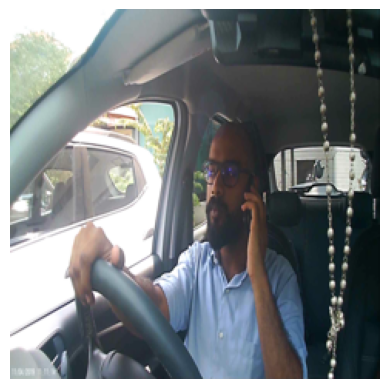

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
CNN Prediction: turning


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
VGG Prediction: texting_phone


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
ResNet34 Prediction: other_activities


In [32]:
# Load Your Models
cnn_model = tf.keras.models.load_model("/kaggle/working/cnn_model.keras")
vgg_model = tf.keras.models.load_model("/kaggle/working/VGG_model.keras")
resnet_model = tf.keras.models.load_model("/kaggle/working/model_ResNet34.keras")

models = {
    "CNN": cnn_model,
    "VGG": vgg_model,
    "ResNet34": resnet_model
}

classes = ['other_activities', 'safe_driving','talking_phone', 'texting_phone', 'turning']

image_path = "/kaggle/input/revitsone-5class/Revitsone-5classes/talking_phone/2019-04-2417-31-49.png"

image = Image.open(image_path).convert("RGB")
image = image.resize((240, 240))
img_array = np.array(image) / 255.0
img_array = np.expand_dims(img_array, axis=0)

plt.imshow(image)
plt.axis("off")
plt.show()

for name, model in models.items():
    prediction = model.predict(img_array)
    predicted_class = classes[np.argmax(prediction)]

    print(f"{name} Prediction: {predicted_class}")


In [33]:
# Load Models
cnn_model = tf.keras.models.load_model("cnn_model.keras")
vgg_model = tf.keras.models.load_model("VGG_model.keras")
resnet_model = tf.keras.models.load_model("model_ResNet34.keras")

models = {
    "CNN": cnn_model,
    "VGG": vgg_model,
    "ResNet34": resnet_model
}

classes = ['other_activities', 'safe_driving', 'talking_phone', 'texting_phone', 'turning']

accuracies = []
model_names = []


Testing Model: CNN
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step
Accuracy = 98.28%

Classification Report:
                  precision    recall  f1-score   support

other_activities       0.99      0.96      0.97       424
    safe_driving       0.99      0.99      0.99       441
   talking_phone       0.98      0.98      0.98       434
   texting_phone       0.99      0.99      0.99       441
         turning       0.96      1.00      0.98       411

        accuracy                           0.98      2151
       macro avg       0.98      0.98      0.98      2151
    weighted avg       0.98      0.98      0.98      2151

Confusion Matrix:


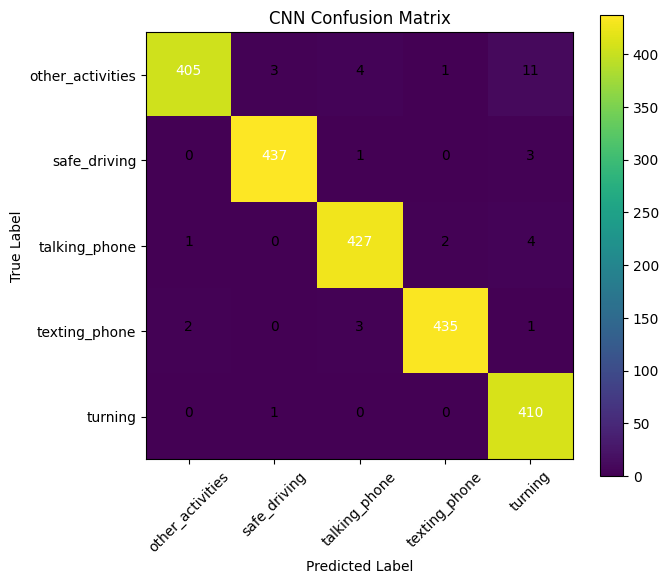


Testing Model: VGG
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step
Accuracy = 96.84%

Classification Report:
                  precision    recall  f1-score   support

other_activities       0.95      0.95      0.95       424
    safe_driving       0.96      0.99      0.98       441
   talking_phone       0.99      0.95      0.97       434
   texting_phone       0.97      0.97      0.97       441
         turning       0.97      0.99      0.98       411

        accuracy                           0.97      2151
       macro avg       0.97      0.97      0.97      2151
    weighted avg       0.97      0.97      0.97      2151

Confusion Matrix:


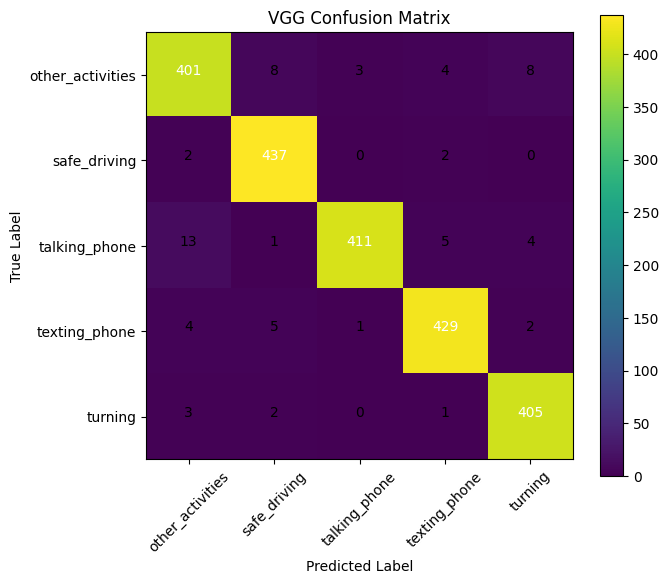


Testing Model: ResNet34
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step
Accuracy = 98.42%

Classification Report:
                  precision    recall  f1-score   support

other_activities       0.97      0.98      0.98       424
    safe_driving       0.99      0.99      0.99       441
   talking_phone       0.99      0.97      0.98       434
   texting_phone       0.99      0.99      0.99       441
         turning       0.98      0.99      0.99       411

        accuracy                           0.98      2151
       macro avg       0.98      0.98      0.98      2151
    weighted avg       0.98      0.98      0.98      2151

Confusion Matrix:


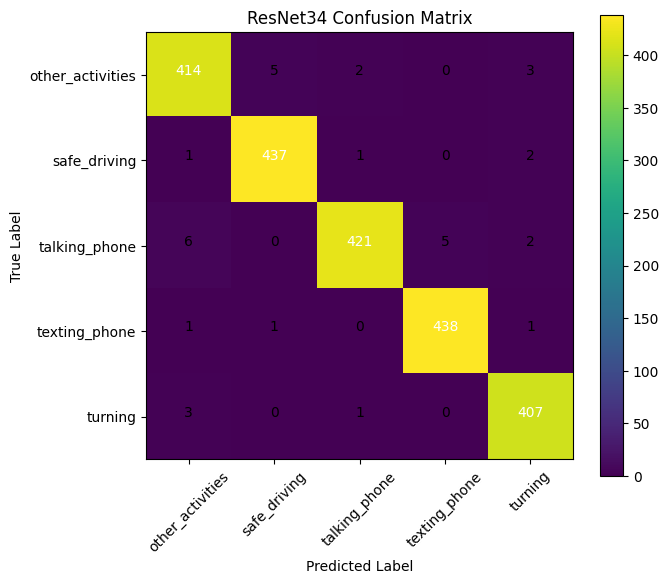

In [35]:
# Test Each Model
for name, model in models.items():

    print("\n" + "="*70)
    print(f"Testing Model: {name}")
    print("="*70)

    # Predict
    predictions = model.predict(test_gen)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes

    # Accuracy
    acc = np.mean(y_pred == y_true) * 100
    accuracies.append(acc)
    model_names.append(name)

    print(f"Accuracy = {acc:.2f}%\n")

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    print("Confusion Matrix:")

    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"{name} Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

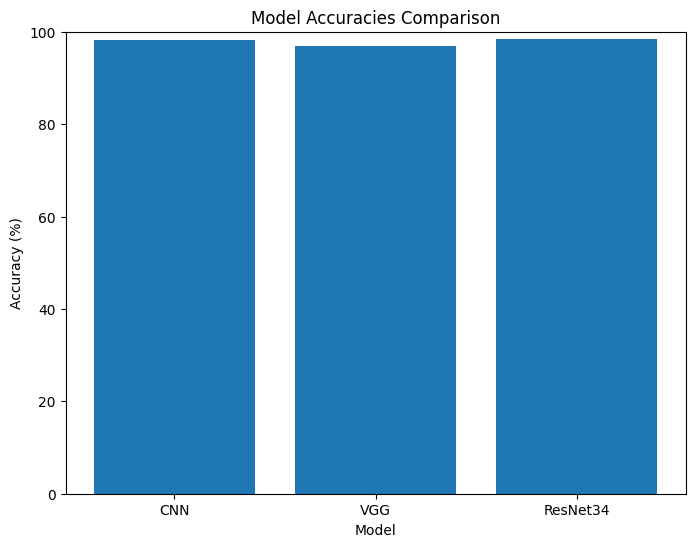



Final Accuracy Summary:
CNN: 98.28%
VGG: 96.84%
ResNet34: 98.42%


In [36]:
# Compare Models in Bar Chart
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies)
plt.title("Model Accuracies Comparison")
plt.ylabel("Accuracy (%)")
plt.xlabel("Model")
plt.ylim(0, 100)
plt.show()

# Print Model Accuracy Table
print("\n\nFinal Accuracy Summary:")
for name, acc in zip(model_names, accuracies):
    print(f"{name}: {acc:.2f}%")
